# BDA1 - Spark

**Submission by:**
- Julius Kittler (julki092)
- Maximilian Pfundstein (maxpf364)

In this set of exercises you will work exclusively with Spark. This means that in your programs, you only need to create the `SparkContext`.
In a number of exercises you will be asked to calculated temperature averages (daily and monthly). These are not always computed according to the standard definition of ‘average’. In this domain the daily average temperature is calculated by averaging the daily measured maximum and the daily measured minimum temperatures. The monthly average is calculated by averaging the daily maximums and minimums for that month. For example, to get the monthly average for October, take maximums and minimums for each day, sum them up and divide by 62 (which is the same as taking the daily averages, summing them up and divide by the number of days).

Note: In many countries in the world, the averages are calculated as discussed. However, in Sweden, daily and monthly averages are calculated using Ekholm-Modéns formula which in addition to minimum and maximum daily temperature also takes into account readings at specific timepoints, the month as well as the longitude of the station. For more information check (in Swedish): http://www.smhi.se/kunskapsbanken/meteorologi/hur-beraknas-medeltemperatur-1.3923

## Setup

The following code is used to prepare the data files, execute only once and **be careful!**

In [1]:
# Remove UTF-8 BOM
#!vim -c ':set nobomb' -c ':set fileencoding=utf-8' -c ':wq' ../data/temperature-readings.csv
#!vim -c ':set nobomb' -c ':set fileencoding=utf-8' -c ':wq' ../data/precipitation-readings.csv
#!vim -c ':set nobomb' -c ':set fileencoding=utf-8' -c ':wq' ../data/stations-Ostergotland.csv
#!vim -c ':set nobomb' -c ':set fileencoding=utf-8' -c ':wq' ../data/stations.csv

# Create big 16GiB file
#for i in range(8):
#    !cat ../data/temperature-readings.csv >> ../data/temperature-readings-big.csv

In [2]:
import pyspark
import csv
import math
import sys
import pandas as pd

tr_path = "../data/temperature-readings.csv"
tr_big_path = "../data/temperature-readings-big.csv"
pr_path = "../data/precipitation-readings.csv"
sro_path = "../data/stations-Ostergotland.csv"
sr_path = "../data/stations.csv"

In [3]:
sc = pyspark.SparkContext(appName = "Temperature")
temperature_readings = sc.textFile(tr_path)
temperature_readings_big = sc.textFile(tr_big_path)
precipitation_readings = sc.textFile(pr_path)
station_oster_readings = sc.textFile(sro_path)
station_readings = sc.textFile(sr_path)

## Assignment 1

What are the lowest and highest temperatures measured each year for the period 1950- 2014. Provide the lists sorted in the descending order with respect to the maximum temperature. In this exercise you will use the `temperature-readings.csv` file.

In [4]:
%%time

res = temperature_readings.map(lambda l: l.split(";"))
res = res.map(lambda l: (int(l[1][0:4]), (float(l[3]), float(l[3]))))
# (year, (temperature, temperature))
res = res.filter(lambda m: m[0] >= 1950 and m[0] <= 2014)
res = res.reduceByKey(lambda x, y: (x[0] if x[0] > y[0] else y[0],
                                    y[1] if x[1] > y[1] else x[1]))
res = res.map(lambda m: (m[0], m[1][0], m[1][1]))
#(year, temp_max, temp_min)
res = res.sortBy(lambda m: m[1], ascending=False)

global df
df = pd.DataFrame(res.collect(), columns = ['year', 'temp_max', 'temp_min'])

CPU times: user 58.5 ms, sys: 29.2 ms, total: 87.7 ms
Wall time: 1min 33s


In [5]:
df.head(10)

,year,temp_max,temp_min
0,1975,36.1,-37.0
1,1992,35.4,-36.1
2,1994,34.7,-40.5
3,2010,34.4,-41.7
4,2014,34.4,-42.5
5,1989,33.9,-38.2
6,1982,33.8,-42.2
7,1968,33.7,-42.0
8,1966,33.5,-49.4
9,2002,33.3,-42.2


**Task 1a:** What are the lowest and highest temperature measured each year for the period 1950 to 2014? Provide the list sorted in the descending order with respect to the maximum temperature. Extend the program to include the station number (not the station name) where the maximum/minimum temperature was measured.

In [6]:
%%time

res = temperature_readings_big.map(lambda l: l.split(";"))
res = res.map(lambda l: (int(l[1][0:4]), ((int(l[0]), float(l[3])), (int(l[0]), float(l[3])))))
# (year, (station, temperature), (station, temperature))
res = res.filter(lambda m: m[0] >= 1950 and m[0] <= 2014)
res = res.reduceByKey(lambda x, y: ((x[0][0], x[0][1]) if x[0][1] > y[0][1] else (y[0][0], y[0][1]),
                                    (y[1][0], y[1][1]) if x[1][1] > y[1][1] else (x[1][0], x[1][1])))
res = res.map(lambda m: (m[0], m[1][0][1], m[1][0][0], m[1][1][1], m[1][1][0]))
#(year, temp_max, station_max, temp_min, station_min)
res = res.sortBy(lambda m: m[1], ascending = False)

global df
df = pd.DataFrame(res.collect(), columns = ['year', 'temp_max', 'station_max', 'temp_min', 'station_min'])

CPU times: user 302 ms, sys: 88.4 ms, total: 390 ms
Wall time: 13min 34s


In [7]:
df.head(10)

,year,temp_max,station_max,temp_min,station_min
0,1975,36.1,86200,-37.0,157860
1,1992,35.4,63600,-36.1,179960
2,1994,34.7,117160,-40.5,179960
3,2010,34.4,75250,-41.7,191910
4,2014,34.4,96560,-42.5,192840
5,1989,33.9,63050,-38.2,166870
6,1982,33.8,94050,-42.2,113410
7,1968,33.7,137100,-42.0,179950
8,1966,33.5,151640,-49.4,179950
9,1983,33.3,98210,-38.2,191900


**Task 1b**: Write the non-parallelized program in Python to find the maximum temperatures for each year without using Spark.

In [8]:
def csv_read_lazy(csvfile, delimiter = ",", encoding = "utf-8"):
    with open(csvfile, encoding = encoding) as f:
        r = csv.reader(f, delimiter = delimiter)
        for row in r:
            yield row

In [9]:
%%time

def get_temperature_information(min_year = 1950, max_year = 2014):
    
    temp_info = {}
    temp_info["max"] = {}
    temp_info["min"] = {}
    
    for year in range(min_year, max_year + 1):
        temp_info["max"][year] = {"temp": float("-Inf"), "station": None}
        temp_info["min"][year] = {"temp": float("Inf"), "station": None}

    for row in csv_read_lazy(tr_big_path, delimiter = ";"):
        year = int(row[1][0:4])
        station = int(row[0])
        temp = float(row[3])
    
        if year >= min_year and year <= max_year:
            # Max
            if temp > temp_info["max"][year]["temp"]:
                temp_info["max"][year]["temp"] = temp
                temp_info["max"][year]["station"] = station
            
            # Min
            if temp < temp_info["min"][year]["temp"]:
                temp_info["min"][year]["temp"] = temp
                temp_info["min"][year]["station"] = station
                
    df = pd.DataFrame(columns=['year', 'temp_max', 'station_max', 'temp_min', 'station_min'])
        
    for year, v in temp_info["max"].items():
        if v["temp"] != float("-Inf"):
            df.loc[len(df)] = [year, v["temp"], v["station"], temp_info["min"][year]["temp"], temp_info["min"][year]["station"]]
    
    df["year"] = df["year"].astype(int)
    df["station_max"] = df["station_max"].astype(int)
    df["station_min"] = df["station_min"].astype(int)
    
    return df.sort_values(by = ['temp_max'], ascending = False)

global df
df = get_temperature_information()

CPU times: user 14min 16s, sys: 8.41 s, total: 14min 25s
Wall time: 14min 26s


In [10]:
df.head(10)

,year,temp_max,station_max,temp_min,station_min
25,1975,36.1,86200,-37.0,157860
42,1992,35.4,63600,-36.1,179960
44,1994,34.7,117160,-40.5,179960
64,2014,34.4,96560,-42.5,192840
60,2010,34.4,75250,-41.7,191910
39,1989,33.9,63050,-38.2,166870
32,1982,33.8,94050,-42.2,113410
18,1968,33.7,137100,-42.0,179950
16,1966,33.5,151640,-49.4,179950
33,1983,33.3,98210,-38.2,191900


**Comment:** We can see that the sequential version takes longer time, but not that much. Parallel computing has some overhead and it depends strongly on the problem if is makes sense to parallelize. Here 4 cores (8 threeads with multi-threading) have been used, so more cores might make the difference larger.

On Heffa, the version without Spark took much longer (ca. 40 minutes longer) than the version with Spark. This is due to the fact that the server CPU was made for parallel computing, so we see a much greater difference here, as it utilizes Spark to it's full potential.

## Assignment 2

Count the number of readings for each month in the period of 1950-2014 which are higher than 10 degrees. Repeat the exercise, this time taking only distinct readings from each station. That is, if a station reported a reading above 10 degrees in some month, then it appears only once in the count for that month. In this exercise you will use the `temperature-readings.csv` file.

The output should contain the following information:

Year, month, count

In [11]:
%%time

res = temperature_readings.map(lambda l: l.split(";"))
res = res.map(lambda l: (int(l[1][0:4]), int(l[1][5:7]), float(l[3])))
res = res.filter(lambda m: int(m[0]) >= 1950 and int(m[0]) <= 2014 and m[2] > 10.0)
res = res.map(lambda m: ((m[0], m[1]), 1))
res = res.reduceByKey(lambda x, y: x + y)
res = res.map(lambda m: (m[0][0], m[0][1], m[1]))
res = res.sortBy(lambda m: (m[0], m[1]), ascending = False)

global df
df = pd.DataFrame(res.collect(), columns = ['year', 'month', 'count'])

CPU times: user 67.8 ms, sys: 12.1 ms, total: 79.9 ms
Wall time: 1min 31s


In [12]:
df.head(10)

,year,month,count
0,2014,12,3
1,2014,11,8139
2,2014,10,42191
3,2014,9,86090
4,2014,8,124045
5,2014,7,147681
6,2014,6,101711
7,2014,5,57250
8,2014,4,19862
9,2014,3,4213


Now we repeat the exercise where we take only distinct readings from each station.

In [13]:
%%time

res = temperature_readings.map(lambda l: l.split(";"))
res = res.map(lambda l: (int(l[0]), int(l[1][0:4]), int(l[1][5:7]), float(l[3])))
res = res.filter(lambda m: int(m[1]) >= 1950 and int(m[1]) <= 2014 and m[3] > 10.0)
res = res.map(lambda m: ((m[0], m[1], m[2]), 1))
res = res.reduceByKey(lambda x, y: x + y)
res = res.map(lambda m: ((m[0][1], m[0][2]), 1))
res = res.reduceByKey(lambda x, y: x + y)
res = res.sortBy(lambda m: (m[0][0], m[0][1]), ascending=False)
res = res.map(lambda m: (m[0][0], m[0][1], m[1]))

global df
df = pd.DataFrame(res.collect(), columns = ['year', 'month', 'count'])

CPU times: user 97.5 ms, sys: 4.22 ms, total: 102 ms
Wall time: 1min 28s


In [14]:
df.head(10)

,year,month,count
0,2014,12,1
1,2014,11,158
2,2014,10,270
3,2014,9,296
4,2014,8,296
5,2014,7,297
6,2014,6,298
7,2014,5,296
8,2014,4,254
9,2014,3,169


## Assignment 3

Find the average monthly temperature for each available station in Sweden. Your result should include average temperature for each station for each month in the period of 1960-2014. Bear in mind that not every station has the readings for each month in this timeframe. In this exercise you will use the `temperature-readings.csv` file.

The output should contain the following information:

Year, month, station number, average monthly temperature

In [15]:
%%time

res = temperature_readings.map(lambda l: l.split(";"))
res = res.map(lambda m: ((int(m[0]), int(m[1].split("-")[0]), int(m[1].split("-")[1]), int(m[1].split("-")[2])), (float(m[3]), float(m[3]))))
res = res.filter(lambda m: m[0][1] >= 1960 and m[0][1] <= 2014)
res = res.reduceByKey(lambda x, y: (max(x[0], y[0]), min(x[1], y[1])))
res = res.map(lambda m: (m[0][0:3], (sum(m[1]), 2)))
res = res.reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))
res = res.map(lambda m: (m[0][1], m[0][2], m[0][0], m[1][0]/m[1][1]))
res = res.sortBy(lambda m: (m[0], m[1], m[2]), ascending=False)

global df
df = pd.DataFrame(res.collect(), columns=['year', 'month', 'station', 'average-temperature'])

CPU times: user 270 ms, sys: 44.2 ms, total: 314 ms
Wall time: 2min 53s


In [16]:
df.head(10)

,year,month,station,average-temperature
0,2014,12,192840,-11.825806
1,2014,12,191910,-11.551613
2,2014,12,191720,-11.870968
3,2014,12,189720,-10.088710
4,2014,12,188850,-7.556452
5,2014,12,188820,-7.472581
6,2014,12,188800,-6.866129
7,2014,12,183750,-9.596774
8,2014,12,182930,-9.766129
9,2014,12,182910,-9.969355


## Assignment 4

Provide  a  list  of  stations  with  their  associated  maximum  measured  temperatures  and maximum  measured  daily  precipitation.  Show  only  those  stations  where  the  maximum temperature is between 25 and 30 degrees and maximum daily precipitation is between 100 mm and 200mm. In this exercise you will use the `temperature-readings.csv` and `precipitation-readings.csv` files. 

The output should contain the following information:

Station number, maximum measured temperature, maximum daily precipitation

**Update:** We now take the correct temperatures (between 25 and 30) and also reduce first to find the maximum for each station and then filter.

In [26]:
%%time

res_p = precipitation_readings.map(lambda l: l.split(";"))
res_t = temperature_readings.map(lambda l: l.split(";"))

res_p = res_p.map(lambda m: (int(m[0]), float(m[3])))
res_p = res_p.reduceByKey(lambda x, y: max(x, y))
res_p = res_p.filter(lambda m: m[1] > 100 and m[1] < 200)

res_t = res_t.map(lambda m: (int(m[0]), float(m[3])))
res_t = res_t.reduceByKey(lambda x, y: max(x, y))
res_t = res_t.filter(lambda m: m[1] > 25 and m[1] < 30)

res = res_t.join(res_p)
res = res.map(lambda m: (m[0], m[1][0], m[1][1]))

global df
df = pd.DataFrame(res.collect(), columns=['station', 'max_temperature', 'max_precipitation'])
res_p.take(10)

CPU times: user 91.3 ms, sys: 19 ms, total: 110 ms
Wall time: 1min 34s


In [27]:
df.head(10)

,station,max_temperature,max_precipitation


## Assignment 5

Calculate the average monthly precipitation for the Östergotland region (list of stations is provided in the separate file) for the period 1993-2016. In order to do this, you will first need to calculate  the  total  monthly  precipitation  for  each  station  before calculating the monthly average (by averaging over stations). In this exercise you will use the `precipitation-readings.csv` and `stations-Ostergotland.csv` files.

HINT (not for the SparkSQL lab): Avoid using joins here! `stations-Ostergotland.csv` is small  and if distributed will cause a number of unnecessary shuffles when joined with precipitation RDD. If you distribute `precipitation-readings.csv` then either repartition your stations RDD to 1 partition or make use of the collect to acquire a python list and broadcast function to broadcast the list to all nodes.

The output should contain the following information:

Year, month, average monthly precipitation

In [19]:
%%time

# Don't remove those, it will break as we're using %%time
global res_p
global res_s

res_p = precipitation_readings.map(lambda l: l.split(";"))
res_s = station_oster_readings.map(lambda l: l.split(";"))

res_s = res_s.map(lambda m: int(m[0])).collect()
res_s = sc.broadcast(value=res_s)

res_p = res_p.map(lambda m: (int(m[0]), int(m[1].split("-")[0]), int(m[1].split("-")[1]), int(m[1].split("-")[2]), float(m[3])))
res_p = res_p.filter(lambda m: m[1] >= 1993 and m[1] <= 2016)

res = res_p.filter(lambda m: m[0] in res_s.value)
res = res.map(lambda m: ((m[0], m[1], m[2]), m[4]))
res = res.reduceByKey(lambda x, y: x + y)

res = res.map(lambda m: ((m[0][1], m[0][2]), (m[1], 1)))
res = res.reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))
res = res.map(lambda m: (int(m[0][0]), m[0][1], m[1][0]/m[1][1]))
res = res.sortBy(lambda m: (m[0], m[1]), ascending=False)

global df
df = pd.DataFrame(res.collect(), columns=['year', 'month', 'average_precipitation'])

CPU times: user 56.3 ms, sys: 16 ms, total: 72.3 ms
Wall time: 34.2 s


In [20]:
df.head(10)

,year,month,average_precipitation
0,2016,7,0.0000
1,2016,6,47.6625
2,2016,5,29.2500
3,2016,4,26.9000
4,2016,3,19.9625
5,2016,2,21.5625
6,2016,1,22.3250
7,2015,12,28.9250
8,2015,11,63.8875
9,2015,10,2.2625


## Assignment 6

Compare the average monthly temperature (find the difference) in the period 1950-2014 for all stations in Östergotland with long-term monthly averages in the period of 1950-1980. Make a plot of your results. 

HINT: The first step is to find the monthly averages for each station. Then, you can average over all stations to acquire the average temperature for a specific year and month. This RDD/DataFrame can beu sed to compute the long-term average by averaging over all the years in the interval.

The out put should contain the following information:

Year, month, difference

In [21]:
%%time

global res_t
global res_s

res_t = temperature_readings.map(lambda l: l.split(";"))
res_s = station_oster_readings.map(lambda l: l.split(";"))

res_s = res_s.map(lambda m: int(m[0])).collect()
res_s = sc.broadcast(value=res_s)

res_t = res_t.map(lambda m: (((int(m[0]), int(m[1].split("-")[0]), int(m[1].split("-")[1]), int(m[1].split("-")[2])), (float(m[3]), float(m[3])))))
res_oster = res_t.filter(lambda m: m[0][1] >= 1950 and m[0][1] <= 2014).filter(lambda m: m[0][0] in res_s.value)
res_oster = res_oster.reduceByKey(lambda x, y: (max(x[0], y[0]), min(x[1], y[1])))
res_oster = res_oster.map(lambda m: (m[0][0:3], (sum(m[1]), 2)))
res_oster = res_oster.reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))
res_oster = res_oster.map(lambda m: ((m[0][1], m[0][2]), (m[1][0]/m[1][1], 1)))
res_oster = res_oster.reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))
res_oster = res_oster.map(lambda m: (m[0][1], (m[0][0], m[1][0]/m[1][1])))
#(month, (year, avg))

res_general = res_t.filter(lambda m: m[0][1] >= 1950 and m[0][1] <= 1980)
res_general = res_general.reduceByKey(lambda x, y: (max(x[0], y[0]), min(x[1], y[1])))
res_general = res_general.map(lambda m: (m[0][0:3], (sum(m[1]), 2)))
res_general = res_general.reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))
# Drops station
res_general = res_general.map(lambda m: ((m[0][1], m[0][2]), (m[1][0]/m[1][1], 1)))
# Drops year
#res_general = res_general.map(lambda m: ((m[0][0], m[0][2]), (m[1][0]/m[1][1], 1)))
res_general = res_general.reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))
res_general = res_general.map(lambda m: (m[0][1], (m[1][0]/m[1][1], 1)))
res_general = res_general.reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))
res_general = res_general.map(lambda m: (m[0], m[1][0]/m[1][1]))
#(month, avg)

res = res_general.join(res_oster)
#(1, (-5.896814611496512, (2012, -1.5940352235658504))) # Just format, don't use the numbers

res = res.map(lambda m: (m[1][1][0], m[0], m[1][1][1] - m[1][0]))
res = res.sortBy(lambda m: (m[0], m[1]), ascending=True)

global df
df = pd.DataFrame(res.collect(), columns=['year', 'month', 'temperature-difference'])
# Next line is needed for plotting
df['date'] = df['year'].map(str) + "-" + df['month'].map(str) + "-01"

CPU times: user 204 ms, sys: 56.6 ms, total: 261 ms
Wall time: 3min 51s


In [22]:
df.head(10)

,year,month,temperature-difference,date
0,1950,1,0.681693,1950-1-01
1,1950,2,4.439573,1950-2-01
2,1950,3,4.090392,1950-3-01
3,1950,4,3.262071,1950-4-01
4,1950,5,2.630177,1950-5-01
5,1950,6,1.318929,1950-6-01
6,1950,7,-0.259488,1950-7-01
7,1950,8,1.624565,1950-8-01
8,1950,9,1.845451,1950-9-01
9,1950,10,1.362217,1950-10-01


In [23]:
# Difference by Year-Month
df['date'] = df['year'].map(str) + "-" + df['month'].map(str)
df.plot.line(x = 'date', y = 'temperature-difference', figsize=(15,10), title = "Difference by Year-Month");

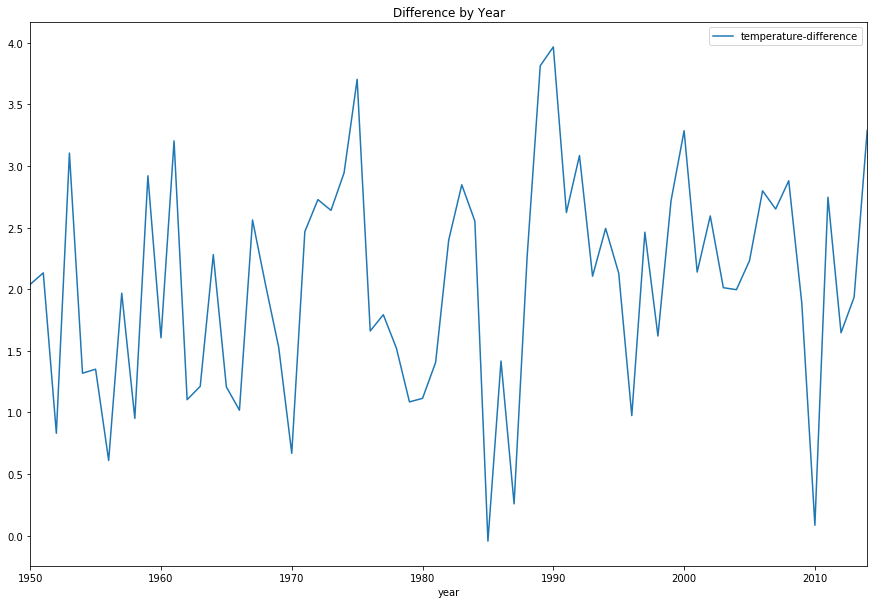

In [24]:
# Difference by Year
df2 = df.groupby(['year'])['temperature-difference'].mean().to_frame()
df2.reset_index(level=0, inplace=True)
df2.plot.line(x = 'year', y = 'temperature-difference', figsize=(15,10), title = "Difference by Year")

**Comment:**  It does not seem like there is a trend across years which makes sense since we don’t expect any temperature changes in the long-term. However, we can observe that there were some years with especially large (e.g. 1990) and especially small temperature differences (e.g. 1985). Hence, the differences may vary noticeably from year to year.

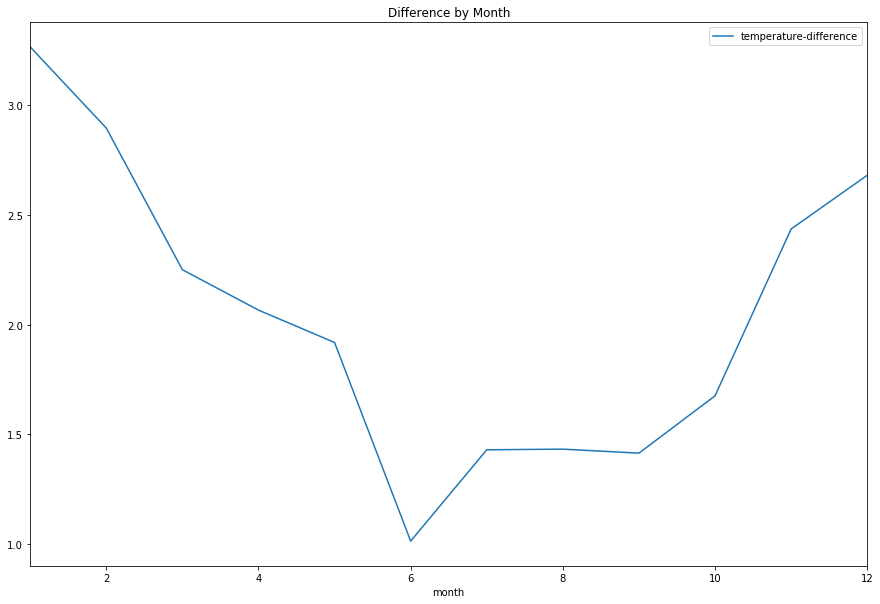

In [25]:
# Difference by Month
df3 = df.groupby(['month'])['temperature-difference'].mean().to_frame()
df3.reset_index(level=0, inplace=True)
df3.plot.line(x = 'month', y = 'temperature-difference', figsize=(15,10), title = "Difference by Month");

**Comment:** We can see that the differences in temperature are much larger in the winter months than in the summer months (see “Difference by Month” plot). This makes sense since we computed the difference as: Difference = Östergotland - General. We expect Östergotland to have warmer temperatures in general than more northern parts of Sweden in the Winter period and Östergotland is in the south. Our expectation is fulfilled since the difference is larger in the winter months.

In [26]:
sc.stop()